# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Topic Analysis - Trump tweets on Twitter



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

In [3]:
import pyjags
import pandas as pd
from rpy2.robjects.packages import importr
r_utils = importr('utils')
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# r_utils.install_packages('coda')
r_coda = importr('coda')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit

In [4]:
import nltk
from collections import Counter
#download only once
# nltk.download('stopwords')  
from matplotlib import gridspec
from scipy.special import logit, expit

Note that this has been tested with 
* pandas version 0.22.0
* rpy2 version 2.9.4

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.


<hr style="height:2pt">

### Problem 1: President Donald Trump's Tweets

In the first part of this assignment, you will be working with text from the @realDonaldTrump Twitter account. This consists of all tweets from the account from 5/4/2009 to 2/26/2019. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted about since President Trump's inauguration.

The dataset is from http://www.trumptwitterarchive.com/archive.

Start by reading the dataset into a pandas data frame.

In [5]:
#read the data file and load it into pandas dataframe
df = pd.read_csv("trump_tweets.csv")
df.head()

,text,created_at
0,Be sure to tune in and watch Donald Trump on L...,05-04-2009 18:54:25
1,Donald Trump will be appearing on The View tom...,05-05-2009 01:00:10
2,Donald Trump reads Top Ten Financial Tips on L...,05-08-2009 13:38:08
3,New Blog Post: Celebrity Apprentice Finale and...,05-08-2009 20:40:15
4,My persona will never be that of a wallflower ...,05-12-2009 14:07:28


In [6]:
df.columns, df.shape

(Index(['text', 'created_at'], dtype='object'), (34118, 2))

In [7]:
pd.isna(df).sum()

text          0
created_at    4
dtype: int64

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
df.shape

(34114, 2)

Now, extract only the rows since President Trump's inauguration on January 20, 2017 (you can use midnight on that date as the start time). You should use the datetime.strptime to convert dates to type `datetime`. Hint: first, you should remove any rows with missing timestamps.

In [14]:
df['created_at'] = pd.to_datetime(df['created_at'])
np.min(df.created_at), np.max(df.created_at)

(Timestamp('2009-05-04 18:54:25'), Timestamp('2019-03-26 14:49:07'))

In [15]:
new_df = df[df['created_at'] >= '01-20-2017 00:00:00'].copy()
np.min(new_df.created_at), np.max(new_df.created_at)

(Timestamp('2017-01-20 00:40:51'), Timestamp('2019-03-26 14:49:07'))

In [16]:
new_df.shape

(6882, 2)

In [17]:
new_df.columns

Index(['text', 'created_at'], dtype='object')

Preprocess the data by making it all lowercase. Remove a reasonable set of stopwords from the dataset and tokenize. Then, report the 50 most common words and their count. You may need to iterate this process, adding some stop words as you understand the structure of the data. Justify additional stop words you've added.


In [19]:
new_df.text=new_df.text.str.lower()
new_df.head()

,text,created_at
27236,thank you for joining us at the lincoln memori...,2017-01-20 00:40:51
27237,thank you for a wonderful evening in washingto...,2017-01-20 04:24:33
27238,it all begins today! i will see you at 11:00 a...,2017-01-20 12:31:53
27239,today we are not merely transferring power fro...,2017-01-20 17:51:25
27240,power from washington d.c. and giving it back ...,2017-01-20 17:51:58


In [20]:
tokenizer = RegexpTokenizer(r'[\w\']+') #Overall, "words" in the corpus are any number of letters, digits, and apostrophes. No hyphens or other fancyness.
stop_words = set(stopwords.words('english'))

stop_words = set(stopwords.words('english'))
stop_words.update(['co','https','rt','amp'])  #removal of website related words
stop_words.update(['u','00','p', 'would', 'realdonaldtrump'])  #removal of website related and other words

In [28]:
text_array=[]
for index, row in new_df.iterrows():
    word_token=tokenizer.tokenize(row['text'])
    purged_word_list=[cur_word for cur_word in word_token if cur_word not in stop_words]
    text_array.append(purged_word_list)

flat_list = [item for sublist in text_array for item in sublist]
counts = Counter(flat_list) 
print('50 Most Common words - ')
display(counts.most_common(50))

50 Most Common words - 


[('co', 2240),
 ('https', 2232),
 ('great', 1518),
 ('amp', 1152),
 ('rt', 1015),
 ('people', 789),
 ('president', 642),
 ('trump', 599),
 ('country', 568),
 ('news', 550),
 ('u', 512),
 ('fake', 495),
 ('big', 481),
 ('thank', 467),
 ('border', 467),
 ('democrats', 465),
 ('many', 464),
 ('today', 435),
 ('america', 416),
 ('get', 407),
 ('time', 394),
 ('new', 372),
 ('much', 338),
 ('would', 336),
 ('american', 335),
 ('realdonaldtrump', 328),
 ('good', 316),
 ('want', 316),
 ('years', 302),
 ('must', 302),
 ('never', 300),
 ('media', 295),
 ('security', 293),
 ('back', 287),
 ('vote', 284),
 ('wall', 283),
 ('one', 280),
 ('make', 278),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('first', 251),
 ('job', 250),
 ('going', 247),
 ('election', 246),
 ('crime', 246)]

In common words, we observe that there are few words like - 'https', 'co', 'rt', 'realdonaldtrump' which are website jargons to tag website/hash tag/account name. We are removing them from word corpus as they will add noise to the topics

In [29]:
stop_words.update(['co','https','rt','amp'])  #removal of website related words
stop_words.update(['u','00','p', 'would', 'realdonaldtrump'])  #removal of website related and other words

In [31]:
#Updating the word corpus using new stoplist
text_array=[]
for index, row in new_df.iterrows():
    word_token=tokenizer.tokenize(row['text'])
    purged_word_list=[cur_word for cur_word in word_token if cur_word not in stop_words]
    text_array.append(purged_word_list)

flat_list = [item for sublist in text_array for item in sublist]
counts = Counter(flat_list) 
counts.most_common(50)

[('great', 1518),
 ('people', 789),
 ('president', 642),
 ('trump', 599),
 ('country', 568),
 ('news', 550),
 ('fake', 495),
 ('big', 481),
 ('thank', 467),
 ('border', 467),
 ('democrats', 465),
 ('many', 464),
 ('today', 435),
 ('america', 416),
 ('get', 407),
 ('time', 394),
 ('new', 372),
 ('much', 338),
 ('american', 335),
 ('good', 316),
 ('want', 316),
 ('years', 302),
 ('must', 302),
 ('never', 300),
 ('media', 295),
 ('security', 293),
 ('back', 287),
 ('vote', 284),
 ('wall', 283),
 ('one', 280),
 ('make', 278),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('first', 251),
 ('job', 250),
 ('going', 247),
 ('election', 246),
 ('crime', 246),
 ('even', 245),
 ('state', 245),
 ('russia', 241),
 ('fbi', 238),
 ('done', 237),
 ('day', 234),
 ('working', 221)]

Find the optimal number of topics using the `u_mass` coherence measure. Plot the results; what does this plot suggest about the number of topics in the text?

In [32]:
masterdictionary = Dictionary(text_array)
mastercorpus = [masterdictionary.doc2bow(doc) for doc in text_array]

In [33]:
len(masterdictionary)

13283

In [34]:
mastercorpus[10], masterdictionary[10]

([(70, 1), (71, 1), (72, 1)], 'tonight')

In [37]:
# u_mass coherence
coherence_vals = []
ntopics=10
for ntop in range(1, ntopics):
    mod = LdaModel(mastercorpus, num_topics = ntop, id2word = masterdictionary, passes=15, random_state=109)
    cmod = CoherenceModel(model=mod, corpus=mastercorpus, dictionary=masterdictionary, coherence='u_mass')
    cval = cmod.get_coherence()
    print(ntop, cval)
    coherence_vals.append(cval)

1 -2.836112813115301
2 -2.811078522113243
3 -2.907078504975352
4 -3.0720272350300735
5 -3.8950218943996404
6 -3.684866289977364
7 -3.600567222131762
8 -4.824266266181133
9 -4.695469031345399


Text(0, 0.5, 'Coherence Score')

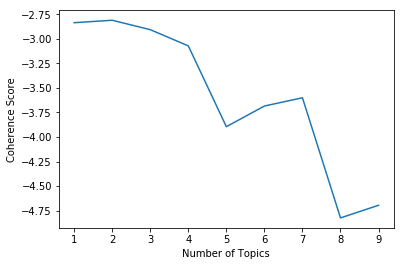

In [39]:
plt.figure(figsize=(6,4))
plt.plot(range(1,ntopics),coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

'U-mass' coherence graph suggests that k=2 is the optimal number of topics.

Run LDA on the texts using the optimal value of $k$ found via your analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility. What does each topic seem to represent?

In [61]:
ntop=3
topicno=LdaModel(mastercorpus, num_topics = ntop, id2word = masterdictionary, passes=15)
top_words=[[word for word,_ in mod.show_topic(topicno, topn=50)] for topicno in range(mod.num_topics)]
top_betas=[[beta for _,beta in mod.show_topic(topicno, topn=50)] for topicno in range(mod.num_topics)]

In [62]:
top_words[0][:10]
top_betas[0][:10]

[0.013323517,
 0.0120026255,
 0.010475214,
 0.009968328,
 0.009657222,
 0.009436673,
 0.008941829,
 0.008506143,
 0.007473585,
 0.0069371383]

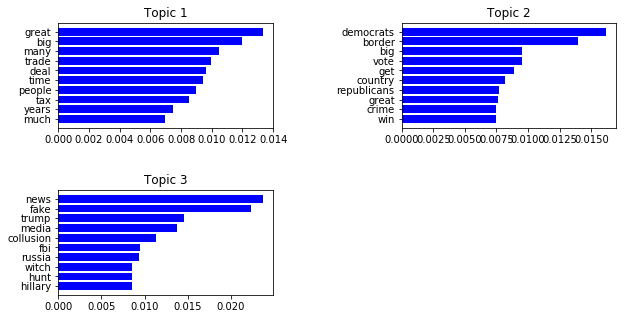

In [63]:
gs  = gridspec.GridSpec(2,2)
gs.update(wspace=0.6, hspace=0.6)
plt.figure(figsize=(10,5))
for i in range(ntop):
    #new subplot
    ax = plt.subplot(gs[i])
    plt.barh(range(10), top_betas[i][:10], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][:10])
    plt.title("Topic "+str(i+1))

Although 'U-mass' coherence graph suggests optimal topics as 2, after few trial and errors we noticed that k=3 was providing meaningful topics and covering more ground. Also the difference between the 'U mass' coherence is not significant for k=2 and 3.